In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential, load_model
#from pyswarm import pso
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.layers import GRU, Dropout, Dense, Activation, Conv1D, MaxPooling1D, Flatten, Reshape,Bidirectional,Input
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tcn.tcn import TCN
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
import warnings
warnings.filterwarnings("ignore")
np.random.seed(120)
tf.random.set_seed(120)
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [2]:
# 获取数据
train = pd.read_csv("./train.csv",index_col=0)
test = pd.read_csv("./test.csv",index_col=0)
train.head()

MMSI       Lon      Lat   SOG  COG  Count
Time                                                                 
2023-09-01 00:00:08  412331000_1  121.0164  38.5864  14.4  319      1
2023-09-01 00:01:03  412331000_1  121.0138  38.5894  14.3  332      2
2023-09-01 00:02:03  412331000_1  121.0123  38.5931  14.0  351      3
2023-09-01 00:03:03  412331000_1  121.0120  38.5971  14.1    0      4
2023-09-01 00:04:03  412331000_1  121.0120  38.6010  14.3  359      5

In [3]:
#数据预处理，步长为10，每连续的10个位置为一组，预测下一个位置
import numpy as np
import pandas as pd

def hav(theta):
    s = np.sin(theta / 2)
    return s * s

def get_distance_hav(lat0, lng0, lat1, lng1):
    EARTH_RADIUS = 6371
    lat0 = np.radians(lat0)
    lat1 = np.radians(lat1)
    lng0 = np.radians(lng0)
    lng1 = np.radians(lng1)

    dlng = np.fabs(lng0 - lng1)
    dlat = np.fabs(lat0 - lat1)
    h = hav(dlat) + np.cos(lat0) * np.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(h))
    return distance


def createSequence(data, window, maxmin=None):
    train_seq = []
    train_label = []
    m, n = maxmin
    window = 10
    for traj_id in set(data['MMSI']):
        data_temp = data.loc[data['MMSI'] == traj_id]
        first_lon = data_temp.loc[data_temp.index[0], 'Lon']
        first_lat = data_temp.loc[data_temp.index[0], 'Lat']
        end_lon = data_temp.loc[data_temp.index[-1], 'Lon']
        end_lat = data_temp.loc[data_temp.index[-1], 'Lat']

        data_temp = np.array(data_temp.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])
        # 标准化
        data_temp = (data_temp - n) / (m - n)

        for i in range(data_temp.shape[0] - window):
            x = []
            for j in range(i, i + window):
                x.append(list(data_temp[j, :]))
            train_seq.append(x)
            train_label.append(data_temp[i + window, :])

    train_seq = np.array(train_seq, dtype='float64')
    train_label = np.array(train_label, dtype='float64')

    return train_seq, train_label


# 多维反归一化
def FNormalizeMult(y_pre, y_true, max_min):
    [m1, n1, s1, c1], [m2, n2, s2, c2] = max_min
    y_pre[:, 0] = y_pre[:, 0] * (m1 - m2) + m2
    y_pre[:, 1] = y_pre[:, 1] * (n1 - n2) + n2
    y_pre[:, 2] = y_pre[:, 2] * (s1 - s2) + s2
    y_pre[:, 3] = y_pre[:, 3] * (c1 - c2) + c2
    y_true[:, 0] = y_true[:, 0] * (m1 - m2) + m2
    y_true[:, 1] = y_true[:, 1] * (n1 - n2) + n2
    y_true[:, 2] = y_true[:, 2] * (s1 - s2) + s2
    y_true[:, 3] = y_true[:, 3] * (c1 - c2) + c2

    # 计算距离
    y_pre = np.insert(y_pre, y_pre.shape[1],
                      get_distance_hav(y_true[:, 1], y_true[:, 0], y_pre[:, 1], y_pre[:, 0]), axis=1)

    return y_pre, y_true


In [4]:
#模型构建
import tensorflow as tf
from tensorflow.keras import layers,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Conv1D, Dropout, Attention, Concatenate,LayerNormalization
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)
def trainModel(train_X, train_Y, test_X, test_Y):
    model = Sequential()
    
    # Step 1: TCN
    input_layer = layers.Input(shape=(train_X.shape[1], train_X.shape[2]))
    #神经元（卷积核）20个，卷积核大小6，膨胀大小为2的次方
    #t=TCN(return_sequences=True,nb_filters=64,kernel_size=5,dilations=[2 ** i for i in range(9)])(input_layer)
    
    # Step 2: Attention Mechanism
    class GlobalAttention(Layer):
        def __init__(self, **kwargs):
            super(GlobalAttention, self).__init__(**kwargs)
    
        def call(self, inputs):
            query, value = inputs
        
            # Compute the dot product between query and key
            score = tf.matmul(query, value, transpose_b=True)
            weights = tf.nn.softmax(score, axis=-1)
        
            # Compute the weighted sum of the values
            attention_output = tf.matmul(weights, value)
        
            return attention_output


    # Apply Dense layers to prepare query, key, and value
    query = Dense(64)(input_layer)
    key = Dense(64)(input_layer)
    value = Dense(64)(input_layer)

    # Apply the global attention mechanism
    attention_output = GlobalAttention()([query, value])

    # Concatenate the attention output with the TCN output
    atten = Concatenate()([input_layer, attention_output])

    #att = Attention()([t, t])
    #atten = Concatenate()([t, att])
    
    #Bi-LSTM层
    bi_lstm = Bidirectional(LSTM(64, return_sequences=False,activation='tanh'))(atten)
    drop = Dropout(0.2)(bi_lstm)
    
    # Step 3: 全连接层
    dense1=Dense(50,activation='tanh')(drop)
    output_layer=Dense(train_Y.shape[1],activation='tanh')(dense1)
    model = Model(inputs=input_layer,outputs=output_layer)
    adam = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=adam, metrics=['acc'])
    # 保存训练过程中损失函数和精确度的变化
    log = CSVLogger(f"./log.csv", separator=",", append=True)
    # 用来自动降低学习率
    reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1, verbose=1,
                               mode='auto', min_delta=0.001, cooldown=0, min_lr=0.001)
    lrs = LearningRateScheduler(scheduler)
    # 模型训练
    model.fit(train_X, train_Y, epochs=50, batch_size=32, verbose=1, validation_split=0.2,
                  callbacks=[log, reduce,lrs])
    # 用测试集评估
    loss, acc = model.evaluate(test_X, test_Y, verbose=1)
    print('Loss : {}, Accuracy: {}'.format(loss, acc * 100))
    # 保存模型
    model.save(f"./model.h5")
    # 打印神经网络结构，统计参数数目
    model.summary()
    return model

In [5]:
# 计算归一化参数
nor = np.array(train.loc[:, ['Lon', 'Lat', 'SOG', 'COG']])

m = nor.max(axis=0)
n = nor.min(axis=0)
maxmin = [m, n]
# 步长
windows = 10
train_seq, train_label = createSequence(train, windows, maxmin)
test_seq, test_label = createSequence(test, windows, maxmin)
# 训练模型
model = trainModel(train_seq, train_label,test_seq,test_label)

Epoch 1/50
1416/1416 [==============================] - 12s 7ms/step - loss: 0.0079 - acc: 0.8340 - val_loss: 0.0032 - val_acc: 0.9111 - lr: 0.0100
Epoch 2/50
1407/1416 [============================>.] - ETA: 0s - loss: 0.0036 - acc: 0.8786
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
1416/1416 [==============================] - 9s 6ms/step - loss: 0.0036 - acc: 0.8782 - val_loss: 0.0033 - val_acc: 0.8809 - lr: 0.0050
Epoch 3/50
1416/1416 [==============================] - ETA: 0s - loss: 0.0031 - acc: 0.8994
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
1416/1416 [==============================] - 9s 6ms/step - loss: 0.0031 - acc: 0.8994 - val_loss: 0.0030 - val_acc: 0.9120 - lr: 0.0025
Epoch 4/50
1416/1416 [==============================] - 9s 6ms/step - loss: 0.0029 - acc: 0.9070 - val_loss: 0.0027 - val_acc: 0.9339 - lr: 0.0025
Epoch 5/50
1413/1416 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9073
Epo

171/171 [==============================] - 1s 3ms/step - loss: 0.0024 - acc: 0.9446
Loss : 0.0023764187935739756, Accuracy: 94.45871710777283
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 4)]              0         []                            
                                                                                                  
 dense (Dense)               (None, 10, 64)               320       ['input_1[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 10, 64)               320       ['input_1[0][0]']             
                                                                                                  
 global_attention (GlobalAt  (None, 10, 64)        

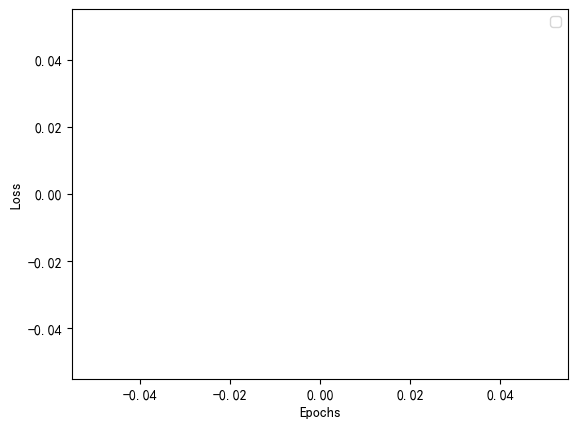

NameError: name 'test_X' is not defined

In [38]:
# 可视化训练过程中的损失值
import matplotlib.pyplot as plt

plt.plot(logs=['loss'], label='train_loss')
plt.plot(logs=['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['频次'])
plt.show()
# 在测试集上评估模型
loss = model.evaluate(test_X, test_Y)
print(f'Test loss: {loss}')

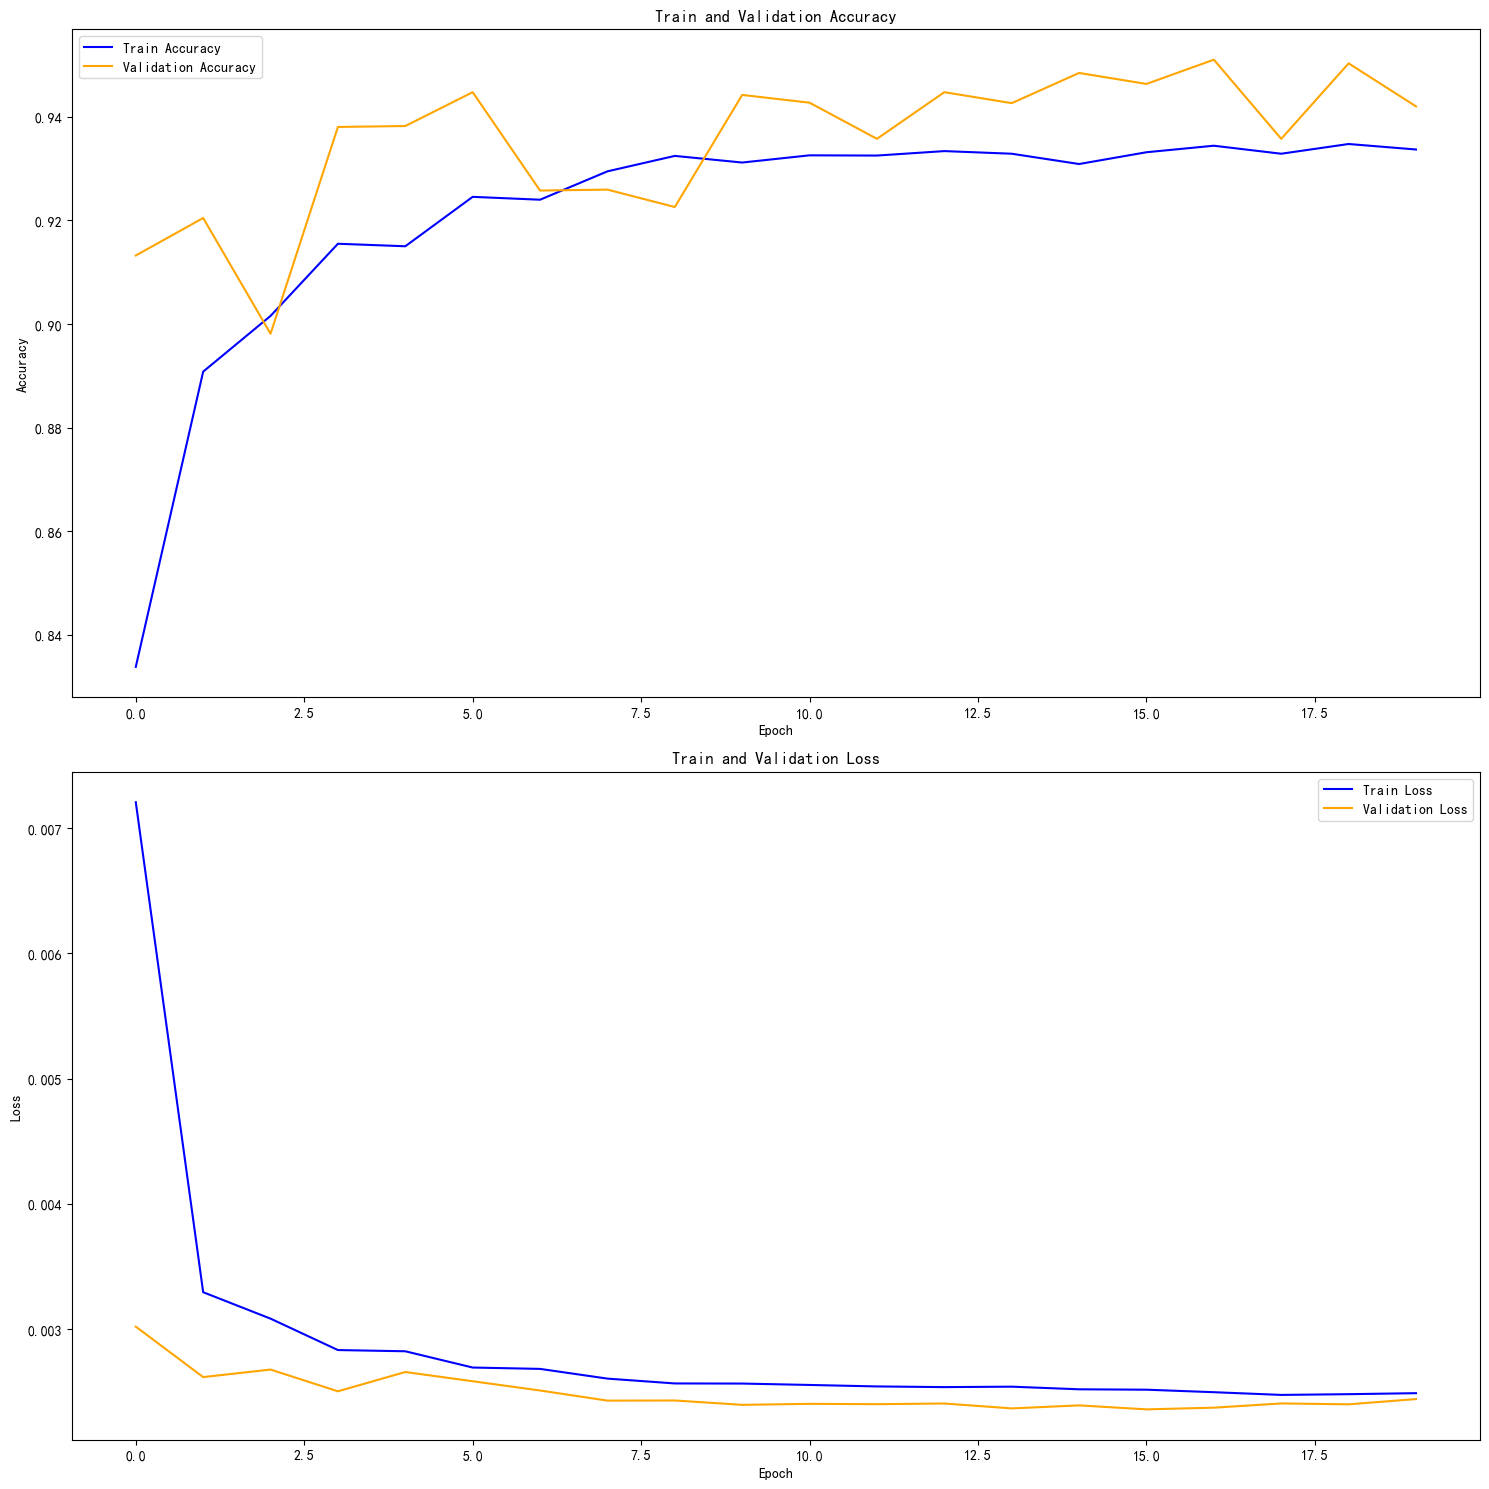

In [15]:
#损失函数和准确率的变化
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.read_csv("./log.csv")

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Plot accuracy
ax[0].plot(logs['epoch'], logs['acc'], label='Train Accuracy', color='blue')
ax[0].plot(logs['epoch'], logs['val_acc'], label='Validation Accuracy', color='orange')
ax[0].set_title('Train and Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot loss
ax[1].plot(logs['epoch'], logs['loss'], label='Train Loss', color='blue')
ax[1].plot(logs['epoch'], logs['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Train and Validation Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 14ms/step
最大值: 0.6628933938185966
最小值: 0.1776340643550237
均值: 0.3546421149462782
方差: 0.011031874148329401
标准差: 0.10503272893879032
中位数: 0.3658100471549941


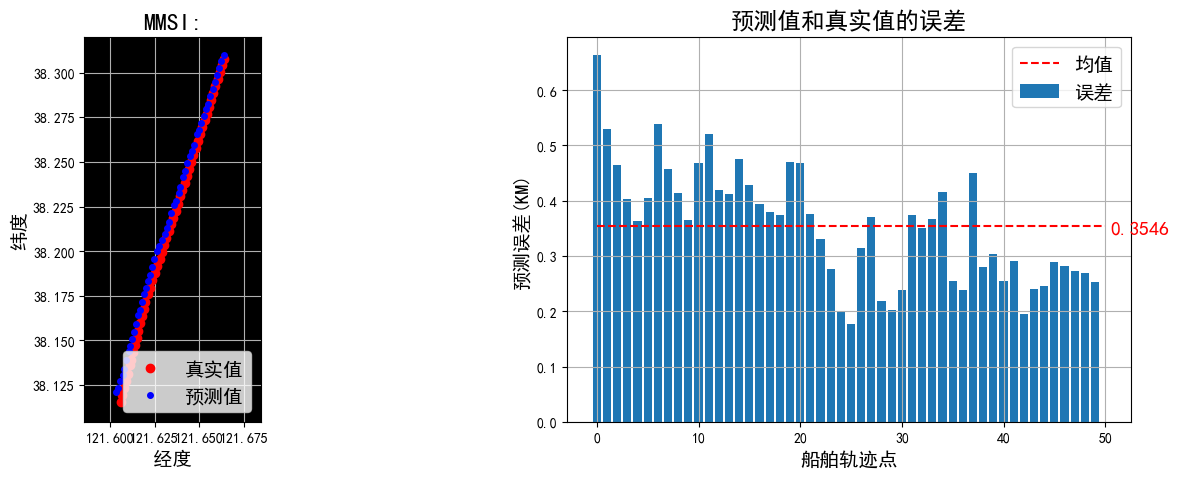

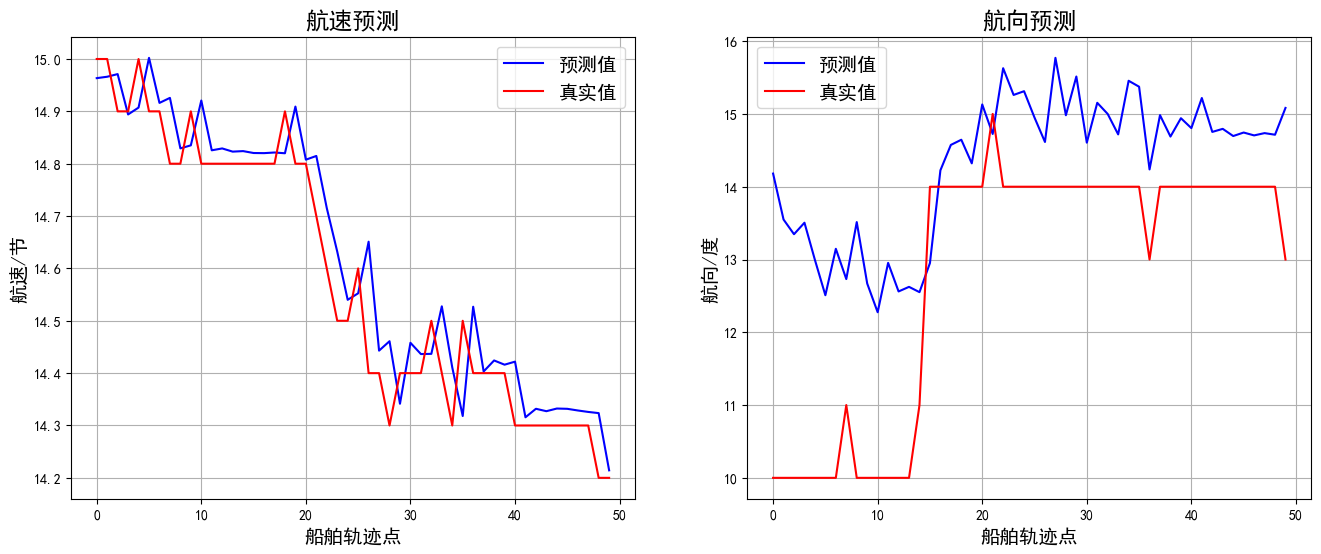

In [41]:
#单步预测
import transbigdata as tbd
test_points_ids = list(set(test['MMSI']))

for ids in test_points_ids[:1]:
    y_pre = []
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)

    y_true = test_label
    for i in range(len(test_seq)):
        y_hat = model.predict(test_seq[i].reshape(1, windows, 4))
        y_pre.append(y_hat[0])
    y_pre = np.array(y_pre, dtype='float64')
    # 反归一化
    f_y_pre, f_y_true = FNormalizeMult(y_pre, y_true, maxmin)

    print(f"最大值: {max(f_y_pre[:, 4])}\n最小值: {min(f_y_pre[:, 4])}\n均值: {np.mean(f_y_pre[:, 4])}\n"
          f"方差: {np.var(f_y_pre[:, 4])}\n标准差: {np.std(f_y_pre[:, 4])}\n中位数: {np.median(f_y_pre[:, 4])}")

    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.plot(f_y_true[:, 0], f_y_true[:, 1], "ro", markersize=6,label='真实值')
    plt.plot(f_y_pre[:, 0], f_y_pre[:, 1], "bo",markersize=4, label='预测值')
    bounds = [min(f_y_true[:, 0])-0.02,min(f_y_true[:, 1])-0.01,max(f_y_true[:, 0])+0.02,max(f_y_true[:, 1])+0.01]
    tbd.plot_map(plt,bounds,zoom = 16,style = 3)
    plt.legend(fontsize=14)
    plt.grid()
    plt.xlabel("经度",fontsize=14)
    plt.ylabel("纬度",fontsize=14)
    plt.title("MMSI:",fontsize=17)

    meanss = np.mean(f_y_pre[:, 4])
    plt.subplot(122)
    plt.bar(range(f_y_pre.shape[0]),f_y_pre[:, 4],label='误差')
    plt.plot([0,f_y_pre.shape[0]],[meanss,meanss],'--r',label="均值")
    plt.title("预测值和真实值的误差",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("预测误差(KM)",fontsize=14)
    plt.text(f_y_pre.shape[0]*1.01,meanss*0.96,round(meanss,4),fontsize=14,color='r')
    plt.grid()
    plt.legend(fontsize=14)

    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    plt.plot(f_y_pre[:, 2], "b-", label='预测值')
    plt.plot(f_y_true[:, 2], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航速预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航速/节",fontsize=14)
    plt.grid()

    plt.subplot(122)
    plt.plot(f_y_pre[:, 3], "b-", label='预测值')
    plt.plot(f_y_true[:, 3], "r-", label='真实值')
    plt.legend(fontsize=14)
    plt.title("航向预测",fontsize=17)
    plt.xlabel("船舶轨迹点",fontsize=14)
    plt.ylabel("航向/度",fontsize=14)
    plt.grid()


In [34]:
test_points_ids = list(set(test['MMSI']))
BP_error_list = []
BP_Pre0 = []
BP_Pre1 = []
BP_Pre2 = []
BP_Pre3 = []
BP_Tre0 = []
BP_Tre1 = []
BP_Tre2 = []
BP_Tre3 = []
for ids in test_points_ids:
    test_seq, test_label = createSequence(test.loc[test.MMSI == ids], windows, maxmin)
    # 要预测的时间
    pre_time = 10
    # 单值预测
    y_pre_BP_50, y_pre_lstm_50, y_pre_GRU_50, y_pre_biLSTM_50, y_pre_bigru_50, y_pre_CNN_RGRU_Attention_50 = [], [], [], [], [], []
    y_true = []

#     for start_id in range(test_seq.shape[0]-int(pre_time)):
    start_id = 0
    pre_seq = test_seq[start_id]
        # 循环预测
    for i in range(int(pre_time)):
        y_hat_BP_50 =model.predict(pre_seq.reshape(1, windows, 4))
            # 其他模型的预测类似...

        y_pre_BP_50.append(y_hat_BP_50[0])
            # 将其他模型的预测结果也添加到相应的列表中...

        y_true.append(test_label[start_id+i])
        # 下一个数组，把预测的值作为预测序列的最后一个值，实现循环预测
        pre_seq = np.insert(pre_seq, pre_seq.shape[0], y_hat_BP_50, axis=0)[1:]
            
    y_pre_BP_50 = np.array(y_pre_BP_50, dtype='float64')
#         y_pre_lstm_50 = np.array(y_pre_lstm_50, dtype='float64')
#         y_pre_GRU_50 = np.array(y_pre_GRU_50, dtype='float64')
#         y_pre_biLSTM_50 = np.array(y_pre_biLSTM_50, dtype='float64')
#         y_pre_bigru_50 = np.array(y_pre_bigru_50, dtype='float64')
#         y_pre_CNN_RGRU_Attention_50 = np.array(y_pre_CNN_RGRU_Attention_50, dtype='float64')

    y_true = np.array(y_true, dtype='float64')
        # 对预测结果进行归一化处理
    f_y_pre_BP_50, f_y_true = FNormalizeMult(y_pre_BP_50, y_true, maxmin)
        # 对其他模型的预测结果也进行相同的处理
#         f_y_pre_lstm_50, f_y_true = FNormalizeMult(y_pre_lstm_50, y_true, maxmin)
#         f_y_pre_GRU_50, f_y_true = FNormalizeMult(y_pre_GRU_50, y_true, maxmin)
#         f_y_pre_biLSTM_50, f_y_true = FNormalizeMult(y_pre_biLSTM_50, y_true, maxmin)
#         f_y_pre_bigru_50, f_y_true = FNormalizeMult(y_pre_bigru_50, y_true, maxmin)
#         f_y_pre_CNN_RGRU_Attention_50, f_y_true = FNormalizeMult(y_pre_CNN_RGRU_Attention_50, y_true, maxmin)


    BP_Pre0.append(list(np.array(f_y_pre_BP_50)[:, 0]))
    BP_Pre1.append(list(np.array(f_y_pre_BP_50)[:, 1]))
    BP_Pre2.append(list(np.array(f_y_pre_BP_50)[:, 2]))
    BP_Pre3.append(list(np.array(f_y_pre_BP_50)[:, 3]))
    BP_Tre0.append(list(np.array(f_y_true)[:, 0]))
    BP_Tre1.append(list(np.array(f_y_true)[:, 1]))
    BP_Tre2.append(list(np.array(f_y_true)[:, 2]))
    BP_Tre3.append(list(np.array(f_y_true)[:, 3]))
    # 将结果添加到错误列表中
#     BP_error_list.append(list(np.array(y_pre_BP_50)[:, 4]))
    # 将其他模型的结果也添加到相应的列表中...




1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


In [36]:
BPP0_data = [item for sublist in BP_Pre0 for item in sublist]
# print(BPP0_data)
BPP1_data = [item for sublist in BP_Pre1 for item in sublist]
# print(BPP1_data)
BPP2_data = [item for sublist in BP_Pre2 for item in sublist]
# print(BPP2_data)
BPP3_data = [item for sublist in BP_Pre3 for item in sublist]
# print(BPP3_data)
BPT0_data = [item for sublist in BP_Tre0 for item in sublist]
# print(BPT0_data)
BPT1_data = [item for sublist in BP_Tre1 for item in sublist]
# print(BPT1_data)
BPT2_data = [item for sublist in BP_Tre2 for item in sublist]
# print(BPT2_data)
BPT3_data = [item for sublist in BP_Tre3 for item in sublist]
# print(BPT3_data)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(BPT0_data, BPP0_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT0_data, BPP0_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT0_data, BPP0_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT1_data, BPP1_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT1_data, BPP1_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT1_data, BPP1_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT2_data, BPP2_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT2_data, BPP2_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT2_data, BPP2_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")
mae = mean_absolute_error(BPT3_data, BPP3_data)
print(f"平均绝对误差（MAE）: {mae}")
mse = mean_squared_error(BPT3_data, BPP3_data)
print(f"均方根误差（MSE）: {mse}")
rmse = np.sqrt(mse)
print(f"均方根误差（RMSE）: {rmse}")
r2 = r2_score(BPT3_data, BPP3_data)
print(f"R2分数（R2_score）: {r2}")
print("--------------------------------------------------")

平均绝对误差（MAE）: 0.00913540529907695
均方根误差（MSE）: 0.00015042081966740195
均方根误差（RMSE）: 0.012264616572376078
R2分数（R2_score）: 0.9987040109169361
--------------------------------------------------
平均绝对误差（MAE）: 0.021807445775300395
均方根误差（MSE）: 0.0010721576905778837
均方根误差（RMSE）: 0.03274381912022304
R2分数（R2_score）: 0.98948390720978
--------------------------------------------------
平均绝对误差（MAE）: 0.5265292206215202
均方根误差（MSE）: 1.9562574324214614
均方根误差（RMSE）: 1.398662730046619
R2分数（R2_score）: 0.3320153966229491
--------------------------------------------------
平均绝对误差（MAE）: 31.933916530101946
均方根误差（MSE）: 7475.256591272383
均方根误差（RMSE）: 86.4595662218611
R2分数（R2_score）: 0.4876200730215755
--------------------------------------------------
